In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from itertools import permutations
import pickle
from sklearn.metrics import mean_squared_error
import plotly.express as px
import matplotlib.pyplot as plt
from matplotlib.patches import Arc

In [43]:
#Read Input Dataset
toRun = pd.read_csv('data/mergedDataset.csv')
toRun.drop(['kickoff_time'],axis=1,inplace=True)

toRun = pd.get_dummies(toRun, columns = ['position'], drop_first=True)

testSet = toRun.loc[((toRun['season_x'] == '2021-22') & (toRun['GW'] == 18))]
X_test = testSet.loc[:,[i for i in list(testSet.columns) if i not in ['total_points', 'name', 'season_x','opp_team_name','team_x']]]
y_test = pd.DataFrame(testSet.loc[:, testSet.columns == 'total_points'])

trainingSet = toRun.loc[((toRun['season_x'] == '2021-22') & (toRun['GW'] != 18))
                        |(toRun['season_x'] == '2016-17')|(toRun['season_x'] == '2017-18')
                       |(toRun['season_x'] == '2018-19')|(toRun['season_x'] == '2019-20')|(toRun['season_x'] == '2020-21')]
X_train = trainingSet.loc[:,[i for i in list(trainingSet.columns) if i not in ['total_points','name', 'season_x','opp_team_name','team_x']]]
y_train = pd.DataFrame(trainingSet.loc[:, trainingSet.columns == 'total_points'])

In [44]:
#Random Forest
model=RandomForestRegressor(n_estimators=300,min_samples_split=5)
model.fit(X_train, y_train)


C:\Users\hrish\AppData\Local\Temp/ipykernel_20356/4226772697.py:3: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



RandomForestRegressor(min_samples_split=5, n_estimators=300)

In [45]:
y_pred=model.predict(X_test)
print('MSE: ', (mean_squared_error(y_test, y_pred)))
finalSet = testSet.copy(deep=True)
finalSet['score'] = y_pred

MSE:  0.061381771114195315


In [60]:

#Check that we have maximum 3 players from each team
def checkTeamLimit(cntTeam):
    cntTeamSet = list(set(cntTeam))
    for i in cntTeamSet:
        counter = 0
        for j in cntTeam:
            if i == j:
                counter += 1
        if counter > 3:
            return False
    return True
#Get the best expected line-up for each formation
def getBestLineup(scoresDF, threshold = [3, 8, 9, 6], budget = 850):
    formations = [[4, 4, 2], [4, 3, 3], [3, 4, 3], [3, 5, 2], [4, 5, 1], [5, 2, 3],[5,4,1]]
    scoresDF = scoresDF.sort_values(by='score', ascending=False)
    weekPointsDF = scoresDF.sort_values(by='total_points', ascending=False)
    expected=[]
    actual=[]
    lineup=[]
    price=[]    
    pvInd = scoresDF.columns.get_loc("value")
    pnInd = scoresDF.columns.get_loc("name")
    wpInd = scoresDF.columns.get_loc("total_points")
    sInd = scoresDF.columns.get_loc("score")
    ptInd = scoresDF.columns.get_loc("team_x")
#     ptInd = "Arsenal"
    
    #Update Current selected permutation of team lineup
    def updateCnt(i, df, cntPrice, cntFor, cntActual, cntScore, line, cntTeam, cntMax):
        cntPrice += df[i, pvInd]
        cntFor.append(df[i, pnInd])
        cntActual += df[i, wpInd]
        cntScore += df[i, sInd]
        cntMax = max(cntMax, df[i, sInd])
        cntTeam.append(df[i, ptInd])
        return cntPrice, cntFor, cntActual, cntScore, cntTeam, cntMax
    GKs = (scoresDF[scoresDF.position_GK == 1]).values
    FWs = (scoresDF[scoresDF.position_FWD == 1]).values
    MDs = (scoresDF[scoresDF.position_MID == 1]).values
    DFs = (scoresDF[(scoresDF.position_GK == 0) & (scoresDF.position_MID == 0) & (scoresDF.position_FWD == 0)]).values
    
    #get Week Dream Team
    GKs2 = weekPointsDF[weekPointsDF.position_GK == 1]
    FWs2 = weekPointsDF[weekPointsDF.position_FWD == 1]
    MDs2 = weekPointsDF[weekPointsDF.position_MID == 1]
    DFs2 = weekPointsDF[(weekPointsDF.position_GK == 0) & (weekPointsDF.position_MID == 0) & (weekPointsDF.position_FWD == 0)]
    DreamTeam = []
    for i in range(threshold[0]):
        DreamTeam.append(GKs2.iloc[i].name)
    for i in range(threshold[1]):
        DreamTeam.append(DFs2.iloc[i].name)
    for i in range(threshold[2]):
        DreamTeam.append(MDs2.iloc[i].name)
    for i in range(threshold[3]):
        DreamTeam.append(FWs2.iloc[i].name)
    
    
    
    #get the best line-up for each formation
    for formation in formations:
        maxi = 0 #Score of Best Line-up
        bestFor = 0 #Best Line-up
        bestPrice = 0 #Price of Best-Lineup
        bestActual = 0 #Actual Score of selected best Formation
        
        #All permutations of Goal Keepers
        gkStr = '1' + '0' * (threshold[0] - 1)
        gks = list(set([''.join(p) for p in permutations(gkStr)]))
        #All permutations of defenders
        dfStr = '1' * formation[0] + '0' * (threshold[1] - formation[0])
        dfs = list(set([''.join(p) for p in permutations(dfStr)]))
        #All permutations of midfielders
        mdStr = '1' * formation[1] + '0' * (threshold[2] - formation[1])
        mds = list(set([''.join(p) for p in permutations(mdStr)]))
        #All permutations of Forwards
        fwStr = '1' * formation[2] + '0' * (threshold[3] - formation[2])
        fws = list(set([''.join(p) for p in permutations(fwStr)]))
        
        #Try all permutations of players
        for gk in gks:
            for df in dfs:
                for md in mds:
                    for fw in fws:
                        #variables to store cnt permutation (Price - Expected Score - Lineup Names - Actual Score)
                        cntPrice = 0
                        cntScore = 0
                        cntFor = []
                        cntActual = 0
                        cntMax = 0 # to know maximum expected points lineup to make the highest one as the captain 
                        cntTeam = []
                        for i in range(len(gk)):
                            if gk[i] == '1':
                                cntPrice, cntFor, cntActual, cntScore, cntTeam, cntMax = updateCnt(i, GKs, cntPrice, cntFor, cntActual, cntScore, 'GKP', cntTeam, cntMax)
                        for i in range(len(df)):
                            if df[i] == '1':
                                cntPrice, cntFor, cntActual, cntScore, cntTeam, cntMax = updateCnt(i, DFs, cntPrice, cntFor, cntActual, cntScore, 'DEF', cntTeam, cntMax)
                        for i in range(len(md)):
                            if md[i] == '1':
                                cntPrice, cntFor, cntActual, cntScore, cntTeam, cntMax = updateCnt(i, MDs, cntPrice, cntFor, cntActual, cntScore, 'MID', cntTeam, cntMax)
                        for i in range(len(fw)):
                            if fw[i] == '1':
                                cntPrice, cntFor, cntActual, cntScore, cntTeam, cntMax = updateCnt(i, FWs, cntPrice, cntFor, cntActual, cntScore, 'FWD', cntTeam, cntMax)
                        
                        cntScore = cntMax + cntScore # Captain Score is doubled
                        if cntPrice <= budget and cntScore > maxi and checkTeamLimit(cntTeam): #Check Budget - Maximum Score - 3 players max from each team 
                            maxi = cntScore
                            bestFor = cntFor
                            bestPrice = cntPrice
                            bestActual = cntActual
        counter = 0
        for p in bestFor:
            if p in DreamTeam:
                counter += 1
        bestPercent = counter / 11.0 * 100
        
        lineup.append(bestFor)
        expected.append(maxi)
        actual.append(bestActual)
        price.append(bestPrice)
#         print('###################### Formation:', formation, '##########################\n', 'Line-Up: ', bestFor)
#         print('Price: ', bestPrice, '\nPredicted Score: ', maxi, '\nActual Score:', bestActual)
    return formations,lineup,expected,actual,price
        

In [61]:
formations,lineup,expected,actual,price=getBestLineup(finalSet)

In [62]:
formations=['4-4-2','4-3-3','3-4-3','3-5-2','4-5-1','5-2-3','5-4-1']

In [63]:
df=pd.DataFrame(list(zip(formations,price,expected,actual,lineup)),columns=['Formations','Price','Predicted','Actual','Lineup'])

In [64]:
df

,Formations,Price,Predicted,Actual,Lineup
0,4-4-2,812,121.299973,105,"[Edouard Mendy, João Pedro Cavaco Cancelo, Ole..."
1,4-3-3,755,117.384652,102,"[Edouard Mendy, João Pedro Cavaco Cancelo, Ole..."
2,3-4-3,801,114.847993,100,"[Edouard Mendy, João Pedro Cavaco Cancelo, Ole..."
3,3-5-2,821,118.638487,103,"[Edouard Mendy, João Pedro Cavaco Cancelo, Ole..."
4,4-5-1,794,123.117332,107,"[Edouard Mendy, João Pedro Cavaco Cancelo, Ole..."
5,5-2-3,756,118.617854,103,"[Edouard Mendy, João Pedro Cavaco Cancelo, Ole..."
6,5-4-1,784,124.536013,108,"[Edouard Mendy, João Pedro Cavaco Cancelo, Ole..."


In [65]:
fig = px.bar(df, x="Formations", y=["Predicted","Actual"],labels={'value':'Points'} ,title="Season 2021-22 Gameweek 8 Points Tally",
             barmode='group')
fig.show()

In [66]:
def add_text(plt,xys,names):    
    c=0
    for i,j in xys:
        split_name=names[c].split(' ')
        if len(split_name)>1:
            nam=split_name[-1]
        else:
            nam=split_name[0]
            
        if names[c]=='Cristiano Ronaldo dos Santos Aveiro':
            nam="Ronaldo"
        if names[c]=='Bernardo Mota Veiga de Carvalho e Silva':
            nam='Bernardo'
        plt.annotate(nam,  xy=(i, j), color='black',
            fontsize="small", weight='heavy',
            horizontalalignment='center',
            verticalalignment='center')
        c=c+1

In [67]:
def createPitch(formation,df):
    msize=40
    #Create figure
    fig=plt.figure()
    ax=fig.add_subplot(1,1,1)
    plt.plot([10],[45], marker="o", markersize=msize, markeredgecolor="black", markerfacecolor="red")   
    gk_name=df.Lineup[df.Formations==formation].values[0][0]
    gk_list=[]
    gk_list.append(gk_name)
    add_text(plt,zip([10],[45]),gk_list)
    
    
    if formation=='4-3-3':
        d_names=df.Lineup[df.Formations==formation].values[0][1:5]
        m_names=df.Lineup[df.Formations==formation].values[0][5:8]
        f_names=df.Lineup[df.Formations==formation].values[0][8:11]
        
        de_x=[33,28,28,33]
        de_y=[13,35,55,77]
        m_x,m_y= [57,82,57], [20,45,70]
        f_x,f_y= [103,120,103], [15,45,75]
        
        plt.plot(de_x, de_y, marker="o", markersize=msize, markeredgecolor="red", markerfacecolor="yellow")
        plt.plot(m_x,m_y ,marker="o", markersize=msize, markeredgecolor="green", markerfacecolor="green")
        plt.plot(f_x,f_y, marker="o", markersize=msize, markeredgecolor="black", markerfacecolor="blue") 
        
        add_text(plt,zip(de_x,de_y),d_names)
        add_text(plt,zip(m_x,m_y),m_names)
        add_text(plt,zip(f_x,f_y),f_names)
        
        
    if formation=='4-4-2':
        d_names=df.Lineup[df.Formations==formation].values[0][1:5]
        m_names=df.Lineup[df.Formations==formation].values[0][5:9]
        f_names=df.Lineup[df.Formations==formation].values[0][9:11]
        
        de_x,de_y=[33,28,28,33], [13,35,55,77]
        m_x,m_y= [52,77,77,52], [20,30,60,70]
        f_x,f_y= [103,103], [30,60]
        
        plt.plot(de_x, de_y, marker="o", markersize=msize, markeredgecolor="red", markerfacecolor="yellow")
        plt.plot(m_x,m_y ,marker="o", markersize=msize, markeredgecolor="green", markerfacecolor="green")
        plt.plot(f_x,f_y, marker="o", markersize=msize, markeredgecolor="black", markerfacecolor="blue") 
        
        add_text(plt,zip(de_x,de_y),d_names)
        add_text(plt,zip(m_x,m_y),m_names)
        add_text(plt,zip(f_x,f_y),f_names)
        
    if formation=='3-4-3':
        d_names=df.Lineup[df.Formations==formation].values[0][1:4]
        m_names=df.Lineup[df.Formations==formation].values[0][4:8]
        f_names=df.Lineup[df.Formations==formation].values[0][8:11]
        
        de_x,de_y= [28,28,28], [20,45,70]
        m_x,m_y= [52,77,77,52], [20,30,60,70]
        f_x,f_y= [103,120,103], [15,45,75]
        
        plt.plot(de_x, de_y, marker="o", markersize=msize, markeredgecolor="red", markerfacecolor="yellow")
        plt.plot(m_x,m_y ,marker="o", markersize=msize, markeredgecolor="green", markerfacecolor="green")
        plt.plot(f_x,f_y, marker="o", markersize=msize, markeredgecolor="black", markerfacecolor="blue") 
        
        add_text(plt,zip(de_x,de_y),d_names)
        add_text(plt,zip(m_x,m_y),m_names)
        add_text(plt,zip(f_x,f_y),f_names)
        
      
        
    if formation=='3-5-2':
        d_names=df.Lineup[df.Formations==formation].values[0][1:4]
        m_names=df.Lineup[df.Formations==formation].values[0][4:9]
        f_names=df.Lineup[df.Formations==formation].values[0][9:11]
        
        de_x,de_y= [28,28,28], [20,45,70]
        m_x,m_y= [72,57,52,57,72], [10,25,45,65,80]
        f_x,f_y= [103,103], [30,60]
        
        plt.plot(de_x, de_y, marker="o", markersize=msize, markeredgecolor="red", markerfacecolor="yellow")
        plt.plot(m_x,m_y ,marker="o", markersize=msize, markeredgecolor="green", markerfacecolor="green")
        plt.plot(f_x,f_y, marker="o", markersize=msize, markeredgecolor="black", markerfacecolor="blue") 
        
        add_text(plt,zip(de_x,de_y),d_names)
        add_text(plt,zip(m_x,m_y),m_names)
        add_text(plt,zip(f_x,f_y),f_names)
        
        
    if formation=='4-5-1':
        d_names=df.Lineup[df.Formations==formation].values[0][1:5]
        m_names=df.Lineup[df.Formations==formation].values[0][5:10]
        f_names=df.Lineup[df.Formations==formation].values[0][10:11]
        
        de_x,de_y= [33,27,27,32], [13,35,55,77]
        m_x,m_y= [52,72,72,52], [15,30,60,75]
        m2_x,m2_y=[92],[45]
        f_x,f_y= [112], [45]
        
        plt.plot(de_x, de_y, marker="o", markersize=msize, markeredgecolor="red", markerfacecolor="yellow")
        plt.plot(m_x,m_y ,marker="o", markersize=msize, markeredgecolor="green", markerfacecolor="green")
        plt.plot(m2_x,m2_y ,marker="o", markersize=msize, markeredgecolor="green", markerfacecolor="green")
        plt.plot(f_x,f_y, marker="o", markersize=msize, markeredgecolor="black", markerfacecolor="blue") 
        
        add_text(plt,zip(de_x,de_y),d_names)
        add_text(plt,zip(m_x,m_y),m_names)
        add_text(plt,zip(m2_x,m2_y),m_names)
        add_text(plt,zip(f_x,f_y),f_names)
        
    if formation=='5-2-3':
        d_names=df.Lineup[df.Formations==formation].values[0][1:6]
        m_names=df.Lineup[df.Formations==formation].values[0][6:8]
        f_names=df.Lineup[df.Formations==formation].values[0][8:11]
        
        de_x,de_y= [35,27,27,27,35], [10,30,45,60,80]
        m_x,m_y= [60,60], [35,65]
        f_x,f_y= [103,120,103], [15,45,75]
        plt.plot(de_x, de_y, marker="o", markersize=msize, markeredgecolor="red", markerfacecolor="yellow")
        plt.plot(m_x,m_y ,marker="o", markersize=msize, markeredgecolor="green", markerfacecolor="green")
        plt.plot(f_x,f_y, marker="o", markersize=msize, markeredgecolor="black", markerfacecolor="blue") 
        
        add_text(plt,zip(de_x,de_y),d_names)
        add_text(plt,zip(m_x,m_y),m_names)
        add_text(plt,zip(f_x,f_y),f_names)
        
    if formation=='5-4-1':
        d_names=df.Lineup[df.Formations==formation].values[0][1:6]
        m_names=df.Lineup[df.Formations==formation].values[0][6:10]
        f_names=df.Lineup[df.Formations==formation].values[0][10:11]
        
        de_x,de_y= [35,27,27,27,35], [10,30,45,60,80]
        m_x,m_y= [52,77,77,52], [20,30,60,70]
        f_x,f_y= [112], [45]
        plt.plot(de_x, de_y, marker="o", markersize=msize, markeredgecolor="red", markerfacecolor="yellow")
        plt.plot(m_x,m_y ,marker="o", markersize=msize, markeredgecolor="green", markerfacecolor="green")
        plt.plot(f_x,f_y, marker="o", markersize=msize, markeredgecolor="black", markerfacecolor="blue") 
        
        add_text(plt,zip(de_x,de_y),d_names)
        add_text(plt,zip(m_x,m_y),m_names)
        add_text(plt,zip(f_x,f_y),f_names)
        
    
#     plt.plot([5,45],gk,color='red')
    #Pitch Outline & Centre Line
    plt.plot([0,0],[0,90], color="black")
    plt.plot([0,130],[90,90], color="black")
    plt.plot([130,130],[90,0], color="black")
    plt.plot([130,0],[0,0], color="black")
    plt.plot([65,65],[0,90], color="black")
    
    #Left Penalty Area
    plt.plot([16.5,16.5],[65,25],color="black")
    plt.plot([0,16.5],[65,65],color="black")
    plt.plot([16.5,0],[25,25],color="black")
    
    #Right Penalty Area
    plt.plot([130,113.5],[65,65],color="black")
    plt.plot([113.5,113.5],[65,25],color="black")
    plt.plot([113.5,130],[25,25],color="black")
    
    #Left 6-yard Box
    plt.plot([0,5.5],[54,54],color="black")
    plt.plot([5.5,5.5],[54,36],color="black")
    plt.plot([5.5,0.5],[36,36],color="black")
    
    #Right 6-yard Box
    plt.plot([130,124.5],[54,54],color="black")
    plt.plot([124.5,124.5],[54,36],color="black")
    plt.plot([124.5,130],[36,36],color="black")
    
    #Prepare Circles
    centreCircle = plt.Circle((65,45),9.15,color="black",fill=False)
    centreSpot = plt.Circle((65,45),0.8,color="black")
    leftPenSpot = plt.Circle((11,45),0.8,color="black")
    rightPenSpot = plt.Circle((119,45),0.8,color="black")
    
    #Draw Circles
    ax.add_patch(centreCircle)
    ax.add_patch(centreSpot)
    ax.add_patch(leftPenSpot)
    ax.add_patch(rightPenSpot)
    
    #Prepare Arcs
    leftArc = Arc((11,45),height=18.3,width=18.3,angle=0,theta1=310,theta2=50,color="black")
    rightArc = Arc((119,45),height=18.3,width=18.3,angle=0,theta1=130,theta2=230,color="black")

    #Draw Arcs
    ax.add_patch(leftArc)
    ax.add_patch(rightArc)
    
    #Tidy Axes
    plt.axis('off')
    plt.title(formation + " Points Expected: " + str(int(df.Predicted[df.Formations==formation].values[0])))
    #Display Pitch
    plt.show()
    


In [68]:

form=df.Formations[df.Predicted==max(df.Predicted)]
form=form.values[0]

Best Formation for the week:



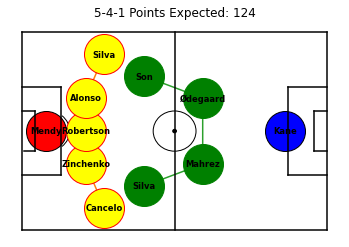

In [69]:
print("Best Formation for the week:\n")
createPitch(form,df)